In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import glob
import os
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

In [2]:
# --- CONFIG ---
BASE_PATH = "Data_sub01" 


# --- 1. LOAD FUNCTION ---
def load_fmri_data():
    # (Simplified loader assuming you cleaned filenames earlier)
    # Using Session 1 as default for demo
    path = f"{BASE_PATH}/beta_images_activation_async/single_trial_sess1/*.nii*"
    files = sorted(glob.glob(path))
    images = [nib.load(f).get_fdata(dtype=np.float32) for f in files]
    # Handle NaNs immediately upon load
    data = np.nan_to_num(np.stack(images, axis=0), nan=0.0)
    
    # Dummy labels (Load your actual CSV here)
    labels = np.zeros(len(data)) 
    return data, labels

# --- 2. AUGMENTATION TECHNIQUES ---

def aug_geo_rotation(X, y, max_angle=5):
    """
    Technique 1 (Geometric): Rotates brain volume.
    Doubles dataset (Original + Rotated).
    """
    print(f"Applying Geometric Augmentation (Rotation)...")
    X_rot = []
    for i in range(len(X)):
        angle = np.random.uniform(-max_angle, max_angle)
        # Rotate on Z-axis (Axial)
        img = rotate(X[i], angle, axes=(0,1), reshape=False, order=1, cval=0.0)
        X_rot.append(img)
    
    # Concatenate Original + New
    return np.concatenate([X, np.array(X_rot)]), np.concatenate([y, y])

def aug_int_noise(X, y, noise_level=0.02):
    """
    Technique 2 (Intensity): Adds Gaussian noise.
    Keeps dataset size same.
    """
    print(f"Applying Intensity Augmentation (Noise)...")
    noise = np.random.normal(0, noise_level, X.shape)
    X_new = X + noise
    # Mask background back to 0
    X_new[X == 0] = 0.0
    return X_new, y

def aug_synth_mixup(X, y, alpha=0.2):
    """
    Technique 3 (Synthesis): Mixup.
    Blends two random images together.
    Doubles dataset (Original + Mixed).
    """
    print(f"Applying Synthesis Augmentation (Mixup)...")
    n_samples = len(X)
    X_mix = []
    y_mix = [] # Note: For classification, y usually needs to be mixed too, or kept as dominant
    
    indices = np.random.permutation(n_samples)
    
    for i in range(n_samples):
        # Lambda (mixing factor)
        lam = np.random.beta(alpha, alpha)
        
        # Mix Image A (current) and Image B (random)
        img_a = X[i]
        img_b = X[indices[i]]
        mixed_img = lam * img_a + (1 - lam) * img_b
        
        X_mix.append(mixed_img)
        # For simplicity in this thesis, we can duplicate label of A (or use mixed labels if using specific loss)
        # Here assuming strict classification, we keep Label A
        y_mix.append(y[i])
        
    return np.concatenate([X, np.array(X_mix)]), np.concatenate([y, np.array(y_mix)])

In [ ]:
X_orig, y_orig = load_fmri_data()
print(f"Original fMRI: {X_orig.shape}")

# Tech 1: Geometric (Rotation)
X_geo, y_geo = aug_geo_rotation(X_orig, y_orig, max_angle=5)

print(f"Geometric: {X_geo.shape}")

# Tech 2: Intensity (Noise) - applied to Original
X_int, y_int = aug_int_noise(X_orig, y_orig, noise_level=0.02)

print(f"Intensity: {X_int.shape}")

# Tech 3: Synthesis (Mixup) - applied to Original
X_syn, y_syn = aug_synth_mixup(X_orig, y_orig, alpha=0.2)

print(f"Synthesis: {X_syn.shape}")

Original fMRI: (162, 79, 95, 79)
Applying Geometric Augmentation (Rotation)...
Geometric: (324, 79, 95, 79)
Applying Intensity Augmentation (Noise)...
Intensity: (162, 79, 95, 79)
Applying Synthesis Augmentation (Mixup)...
Synthesis: (324, 79, 95, 79)


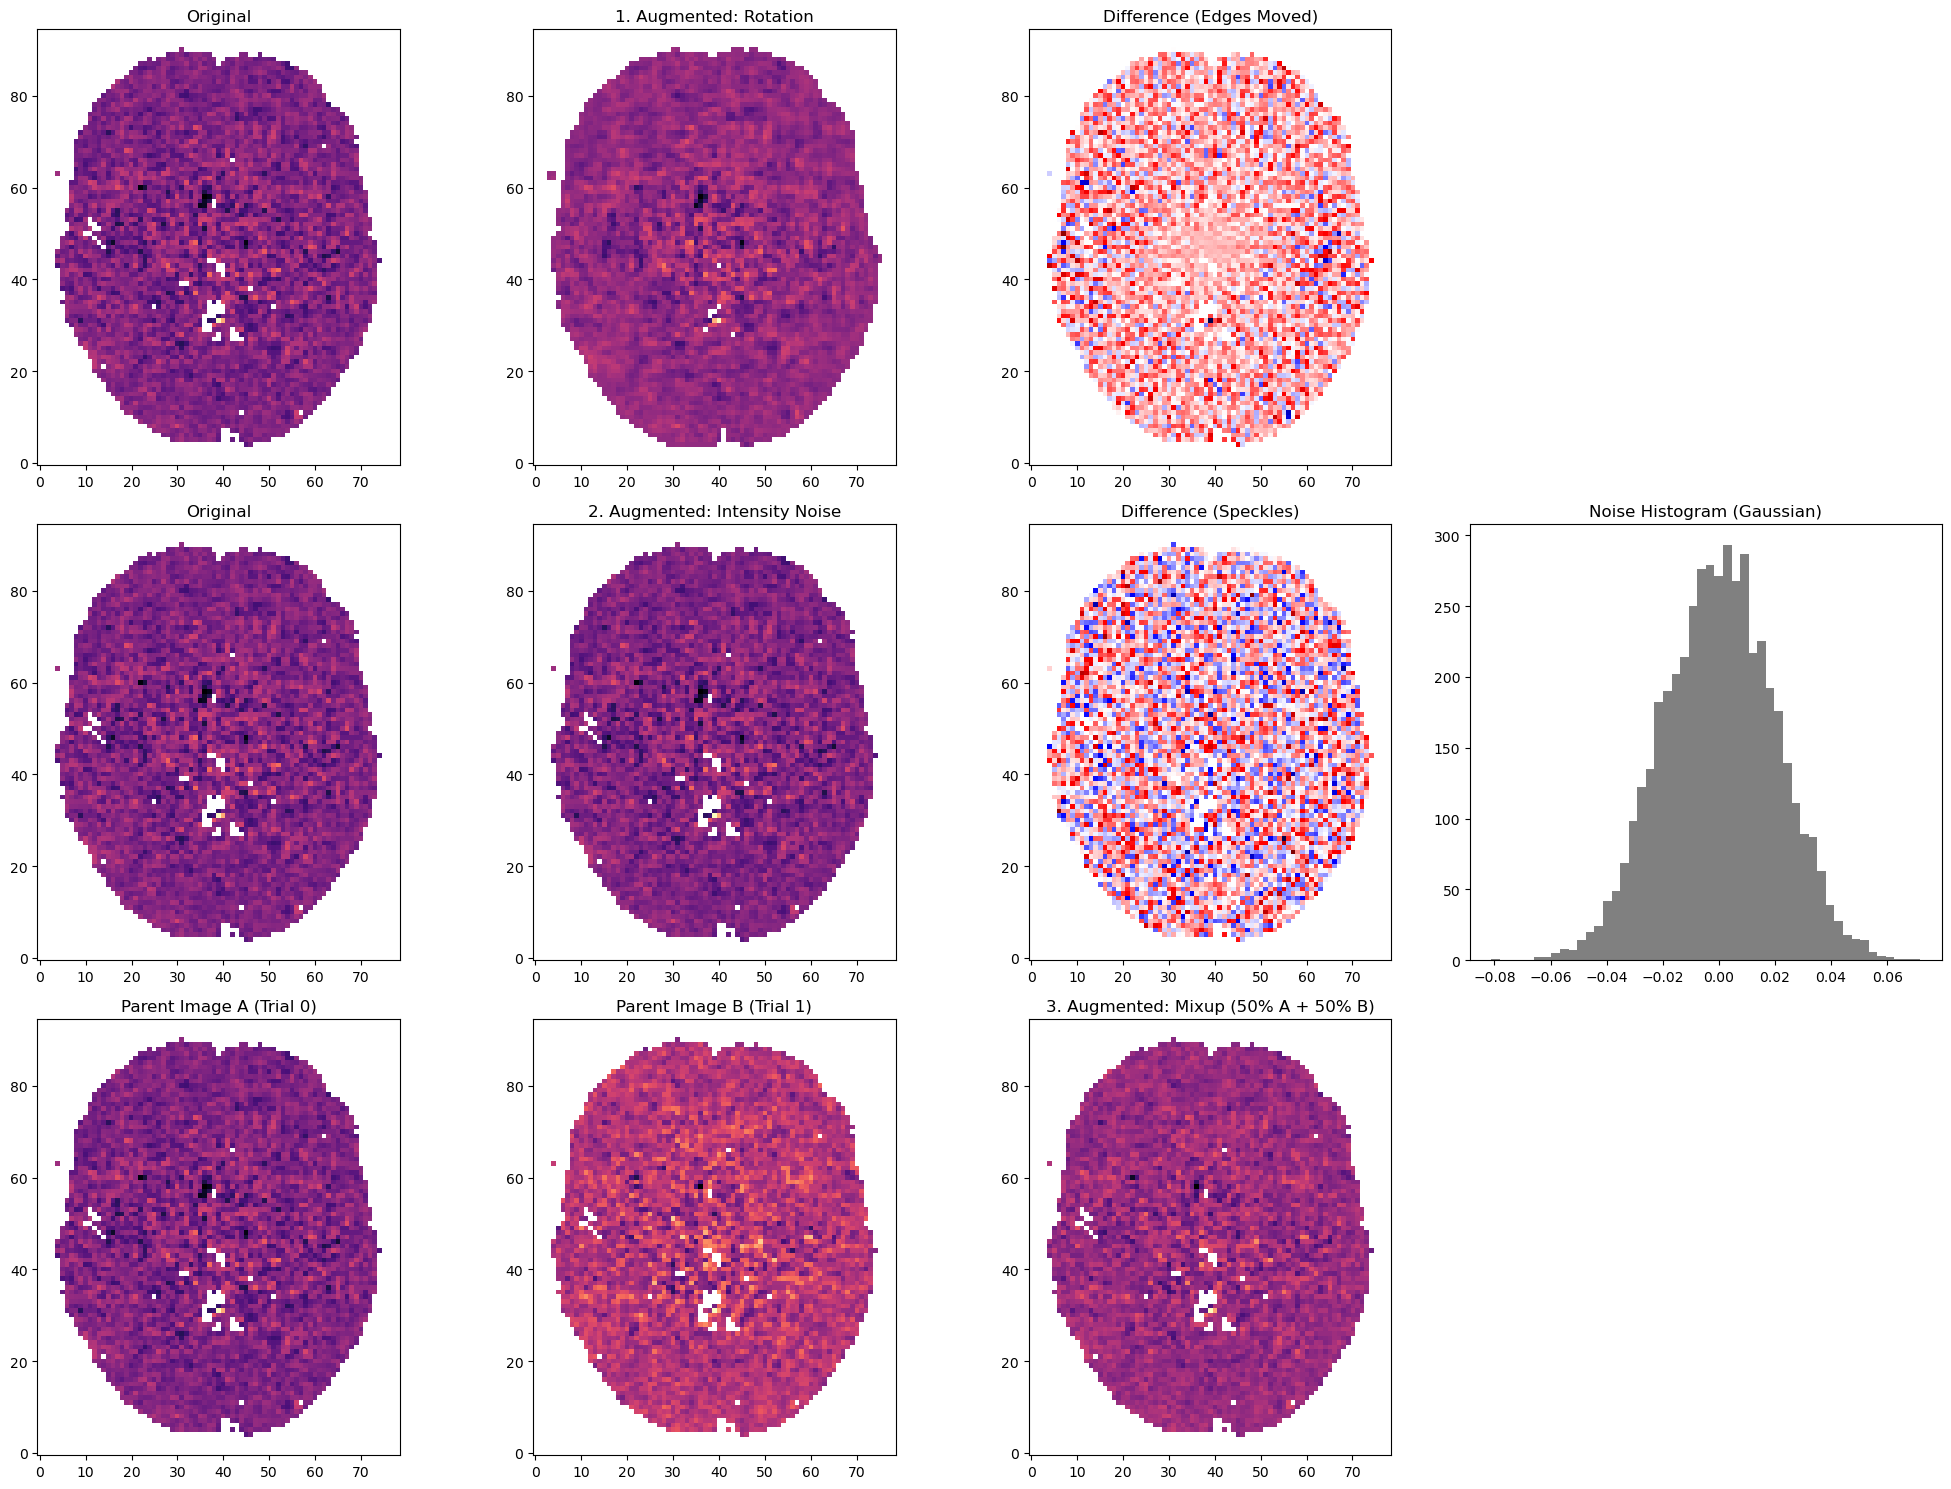

In [4]:
def plot_all_fmri_aug(X_orig, X_geo, X_int, X_syn, trial_idx=0):
    """
    Master plotter for all 3 fMRI augmentations.
    """
    z_slice = X_orig.shape[3] // 2
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    # Helper to mask background 0s
    def get_slice(data, idx):
        slc = data[idx, :, :, z_slice]
        return np.ma.masked_where(slc==0, slc)

    # ==========================================
    # 1. GEOMETRIC (Rotation)
    # ==========================================
    # Row 0
    orig = get_slice(X_orig, trial_idx)
    # Find matching rotated image (it's in the 2nd half of X_geo)
    rot_idx = len(X_orig) + trial_idx
    aug = get_slice(X_geo, rot_idx)
    
    axes[0,0].imshow(orig.T, cmap='magma', origin='lower')
    axes[0,0].set_title("Original")
    
    axes[0,1].imshow(aug.T, cmap='magma', origin='lower')
    axes[0,1].set_title("1. Augmented: Rotation")
    
    axes[0,2].imshow((aug - orig).T, cmap='seismic', origin='lower')
    axes[0,2].set_title("Difference (Edges Moved)")
    axes[0,3].axis('off')

    # ==========================================
    # 2. INTENSITY (Noise)
    # ==========================================
    # Row 1
    # X_int is same size as X_orig (1-to-1)
    aug_int = get_slice(X_int, trial_idx)
    
    axes[1,0].imshow(orig.T, cmap='magma', origin='lower')
    axes[1,0].set_title("Original")
    
    axes[1,1].imshow(aug_int.T, cmap='magma', origin='lower')
    axes[1,1].set_title("2. Augmented: Intensity Noise")
    
    diff_int = aug_int - orig
    axes[1,2].imshow(diff_int.T, cmap='seismic', origin='lower')
    axes[1,2].set_title("Difference (Speckles)")
    
    # Zoom in to see the noise better
    axes[1,3].hist(diff_int.compressed().flatten(), bins=50, color='gray')
    axes[1,3].set_title("Noise Histogram (Gaussian)")

    # ==========================================
    # 3. SYNTHESIS (Mixup)
    # ==========================================
    # Row 2
    # We need to find which two images were mixed. 
    # For visualization, let's just manually mix two images to show the concept
    # since we didn't save the indices in the previous script.
    
    img_A = get_slice(X_orig, 0)
    img_B = get_slice(X_orig, 1) # Next trial
    mixed = 0.5 * img_A + 0.5 * img_B
    
    axes[2,0].imshow(img_A.T, cmap='magma', origin='lower')
    axes[2,0].set_title("Parent Image A (Trial 0)")
    
    axes[2,1].imshow(img_B.T, cmap='magma', origin='lower')
    axes[2,1].set_title("Parent Image B (Trial 1)")
    
    axes[2,2].imshow(mixed.T, cmap='magma', origin='lower')
    axes[2,2].set_title("3. Augmented: Mixup (50% A + 50% B)")
    
    axes[2,3].axis('off')

    plt.tight_layout()
    plt.show()

# --- RUN IT ---
if 'X_geo' in locals():
    plot_all_fmri_aug(X_orig, X_geo, X_int, X_syn)